<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_MyVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import random

SHAPES = ["triangle", "circle"]
PLURALS = [shape + "s" for shape in SHAPES]
ARTICLES = ["a", "one"]
TWO_ARTICLES = ["two"]
CONNECTORS = ["and", "then"]
REVERSE_CONNECTORS = ["after"]
CLASS_TOKEN = "CLS"
MASK_TOKEN = "MASK"
SEP_TOKEN = "SEP"
PAD_TOKEN = "PAD"
EOS_TOKEN = "EOS"
SPECIAL_TOKENS = [CLASS_TOKEN, MASK_TOKEN, SEP_TOKEN, PAD_TOKEN, EOS_TOKEN]
VOCABULARY = SHAPES + PLURALS + ARTICLES + CONNECTORS + REVERSE_CONNECTORS + TWO_ARTICLES + SPECIAL_TOKENS
MAX_LEN_SENTENCE = 16 # Maximum possible length of a sequence

image_width = 16

def generate_random_shapes():
  num_shapes = random.randint(1, 4)
  result = []
  for _ in range(num_shapes):
    result.append(random.choice(SHAPES))
  return result

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def generate_image(word_list, filename, mask_filename):
    # Create a blank 32x32 image
    image_size = image_width
    patch_size = image_width // 2
    image = Image.new("1", (image_size, image_size), 1)  # '1' for 1-bit pixels, black and white
    mask = Image.new("1", (image_size, image_size), 1)

    for i, word in enumerate(word_list):
        if word not in ["triangle", "circle"]:
            continue

        # Determine the top-left corner of the patch
        x_offset = (i % 2) * patch_size
        y_offset = (i // 2) * patch_size

        # Draw the shape in the corresponding patch
        draw = ImageDraw.Draw(image)
        draw_mask = ImageDraw.Draw(mask)
        if word == "triangle":
            points = [(random.randint(x_offset, x_offset + patch_size), random.randint(y_offset, y_offset + patch_size)) for _ in range(3)]
            draw.polygon(points, fill=0)
            draw_mask.polygon(points, fill=0)
        elif word == "circle":
            radius = random.randint(2, patch_size // 2)
            center_x = random.randint(x_offset + radius, x_offset + patch_size - radius)
            center_y = random.randint(y_offset + radius, y_offset + patch_size - radius)
            draw.ellipse([center_x - radius, center_y - radius, center_x + radius, center_y + radius], fill=0)

    # Save the image to the specified filename
    image.save(filename)
    mask.save(mask_filename)

def plot_image(filename):
    # Open the image
    image = Image.open(filename)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage:
generate_image(["circle", "triangle", "circle"], "output_image.png", "masked_output_image.png")

In [13]:
def generate_data(n_samples):
  examples = []
  for i in range(n_samples):
    shape_list = generate_random_shapes()
    filename = f"f{i}.png"
    mask_filename = f"m{i}.png"
    generate_image(shape_list, filename, mask_filename)
    examples.append({"shape_list": shape_list, "filename": filename, "mask_filename": mask_filename})
  return examples

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [15]:
class FigureDataset(Dataset):
    def __init__(self, n_samples, image_dir=".", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.examples = generate_data(n_samples)
        self.image_files = [e["filename"] for e in self.examples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')

        if self.transform:
            image = self.transform(image)

        return image

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the VAE model
class MyVAE(nn.Module):
    def __init__(self, latent_dim, img_width):
        super(MyVAE, self).__init__()

        self.img_width = img_width

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * (img_width // 4) * (img_width // 4), latent_dim)
        self.fc_logvar = nn.Linear(64 * (img_width // 4) * (img_width // 4), latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64 * (img_width // 4) * (img_width // 4))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(-1, 64, self.img_width // 4, self.img_width // 4)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [34]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = FigureDataset(n_samples=2000, image_dir=".", transform=transform)

In [38]:
# prompt: Train the diffusion model above using the given MLP
from tqdm import tqdm

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

latent_dim = 32
model = MyVAE(latent_dim=latent_dim, img_width=image_width)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

batch_size = 32
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

num_epochs = 800

model.train()
losses = []
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0
  for batch in train_loader:
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(batch)
    loss = vae_loss(recon_batch, batch, mu, logvar)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  losses.append(epoch_loss)
  # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

100%|██████████| 800/800 [10:41<00:00,  1.25it/s]


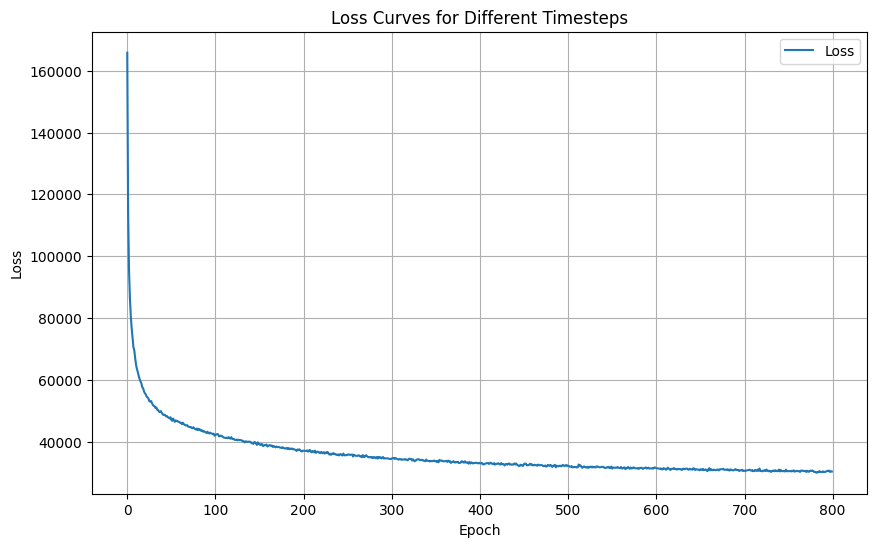

In [39]:
# prompt: Plot the loss curves generated above

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Timesteps')
plt.legend()
plt.grid(True)
plt.show()


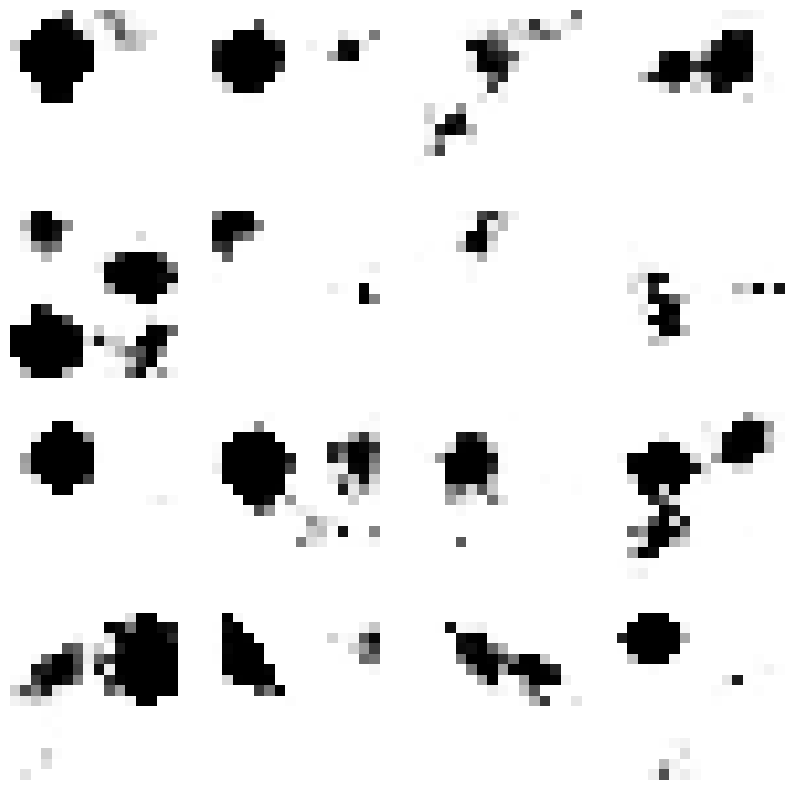

In [40]:
# prompt: Generate sample images from the VAE above

# Generate sample images
num_samples = 16
with torch.no_grad():
    sample = torch.randn(num_samples, latent_dim)
    sample = model.decode(sample).cpu()

# Display the generated images
fig, axes = plt.subplots(figsize=(10, 10), nrows=4, ncols=4)
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(sample[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()


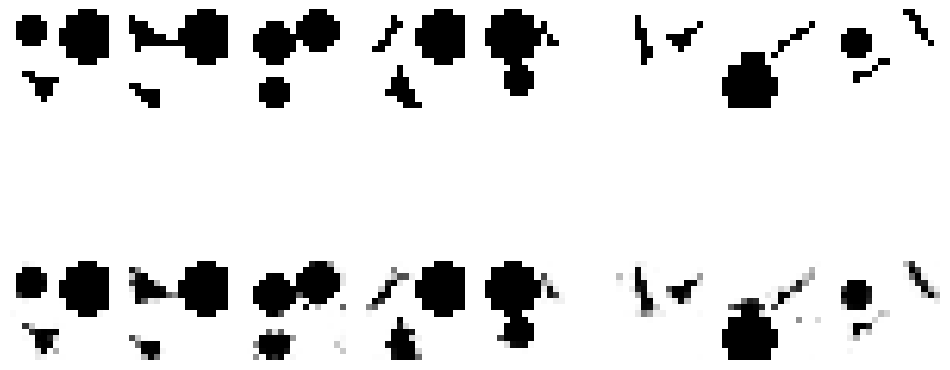

In [41]:
# prompt: Print a set of original images and their reconstruction by the VAE

# Get a batch of images from the dataset
dataiter = iter(train_loader)
images = next(dataiter)

# Reconstruct the images using the VAE
with torch.no_grad():
    recon_images, _, _ = model(images)

# Display the original and reconstructed images
fig, axes = plt.subplots(figsize=(12, 6), nrows=2, ncols=8)
for i in range(8):
    # Original image
    ax = axes[0, i]
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.axis('off')

    # Reconstructed image
    ax = axes[1, i]
    ax.imshow(recon_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')

plt.show()
